## Crop parameters wrt to std bbx

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple
import math

In [2]:
BoundingBox = namedtuple('BoundingBox', 'cx cy w h')

In [3]:
def getRGBImage(image_):
    if image_.ndim == 3:
        if image_.shape[2] == 3:
            image = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        elif image_.shape[2] == 4:
            image = cv2.cvtColor(image_, cv2.COLOR_BGRA2RGBA)
        else:
            image = image_
    else:
        image = image_
    return image

In [4]:
def plotOpenCVImage(image_):
    plt.imshow(getRGBImage(image_))

In [5]:
def getTightBBox(image):
    alpha = image[:,:,3].astype(bool)
    nonzero_idxs = np.nonzero(alpha)
    left = nonzero_idxs[1].min()
    right = nonzero_idxs[1].max() + 1
    top = nonzero_idxs[0].min()
    bottom = nonzero_idxs[0].max() + 1
    
    w = right - left
    h = bottom - top

    cx = (left + right) / 2.0
    cy = (bottom + top) / 2.0
    
    return BoundingBox(cx, cy, w, h)

In [6]:
def getRectanglePatch(bbx, linewidth=1, edgecolor='r'):
    x = math.floor(bbx.cx - bbx.w/2.0)
    y = math.floor(bbx.cy - bbx.h/2.0) 
    return plt.Rectangle((x, y), bbx.w, bbx.h, fill=False, linewidth = linewidth, edgecolor = edgecolor)

In [7]:
def cropImage(image, bbx):
    left = int(math.floor(bbx.cx - bbx.w/2.0))
    right = int(math.floor(bbx.cx + bbx.w/2.0))
    top = int(math.floor(bbx.cy - bbx.h/2.0))
    bottom = int(math.floor(bbx.cy + bbx.h/2.0))
    return image[top:bottom, left:right]

In [8]:
def getBbxExtremes(bbx):
    left = (bbx.cx - bbx.w/2.0)
    right = (bbx.cx + bbx.w/2.0)
    top = (bbx.cy - bbx.h/2.0)
    bottom = (bbx.cy + bbx.h/2.0)
    return np.array([left,top,1.0]), np.array([right,bottom,1.0])

In [9]:
def makeBbxFromExtremes(bbx_min, bbx_max):
    w = bbx_max[0] - bbx_min[0]
    h = bbx_max[1] - bbx_min[1]
    cx = (bbx_min[0] + bbx_max[0]) / 2.0
    cy = (bbx_min[1] + bbx_max[1]) / 2.0
    return BoundingBox(cx, cy, w, h)

In [10]:
std_bbx = BoundingBox(960/2.0, 540/2.0, 960.0, 540.0 )
std_cam_distance = 2.0
current_cam_distance = 4.0

In [11]:
d_img = cv2.imread('../build/render4cnn_d4.png',cv2.IMREAD_UNCHANGED)
d_bbx = getTightBBox(d_img)
print 'd_bbx = ', d_bbx

d_bbx =  BoundingBox(cx=481.5, cy=276.5, w=219, h=93)


In [12]:
d_crop_bbx = BoundingBox(d_bbx.cx + 25, d_bbx.cy + 20, d_bbx.w - 30, d_bbx.h + 15 )
print 'd_crop_bbx = ', d_crop_bbx
d_crop_img = cropImage(d_img, d_crop_bbx)
d_crop_img.shape

d_crop_bbx =  BoundingBox(cx=506.5, cy=296.5, w=189, h=108)


(108, 189, 4)

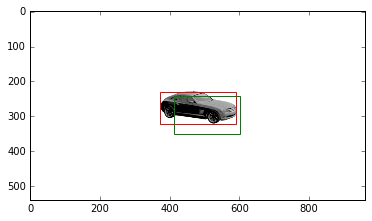

In [13]:
fig,ax = plt.subplots(1)
ax.imshow(getRGBImage(d_img))
ax.add_patch(getRectanglePatch(d_bbx, edgecolor='r'))
ax.add_patch(getRectanglePatch(d_crop_bbx, edgecolor='g'))
plt.show()

In [14]:
d2_img = cv2.imread('../build/render4cnn_d2.png',cv2.IMREAD_UNCHANGED)
d2_bbx = getTightBBox(d2_img)
print 'd2_bbx = ', d2_bbx

d2_bbx =  BoundingBox(cx=487.0, cy=288.0, w=438, h=192)


In [15]:
# We want to find the positions of the bounding box extremes in the standard camera
# We make use of MVG 9.6 (See pg 249)
# Kt/z = [0, 0, t/z]    t = 2 - d, z = d
# Also we assume image center to be origin

t = std_cam_distance - current_cam_distance

kt_by_z = np.array([0,0,t/current_cam_distance])

d_crop_bbx_min, d_crop_bbx_max = getBbxExtremes(d_crop_bbx)

print d_crop_bbx_min
print d_crop_bbx_max

d_crop_bbx_min[:2] -= np.array([480.0,270.0])
d_crop_bbx_max[:2] -= np.array([480.0,270.0])

print d_crop_bbx_min
print d_crop_bbx_max

d_crop_bbx_min += kt_by_z
d_crop_bbx_max += kt_by_z
d_crop_bbx_min = d_crop_bbx_min[:2]/d_crop_bbx_min[2]
d_crop_bbx_max = d_crop_bbx_max[:2]/d_crop_bbx_max[2]


d_crop_bbx_min[:2] += np.array([480.0,270.0])
d_crop_bbx_max[:2] += np.array([480.0,270.0])

d_crop_bbx_wrt_std2 = makeBbxFromExtremes(d_crop_bbx_min, d_crop_bbx_max)

print 'd_crop_bbx_wrt_std2 = ', d_crop_bbx_wrt_std2

[ 412.   242.5    1. ]
[ 601.   350.5    1. ]
[-68.  -27.5   1. ]
[ 121.    80.5    1. ]
d_crop_bbx_wrt_std2 =  BoundingBox(cx=533.0, cy=323.0, w=378.0, h=216.0)


In [16]:
fig,ax = plt.subplots(1)
ax.imshow(getRGBImage(d2_img))
ax.add_patch(getRectanglePatch(d2_bbx, edgecolor='r'))
ax.add_patch(getRectanglePatch(d_crop_bbx_wrt_std2, edgecolor='g'))
plt.show()

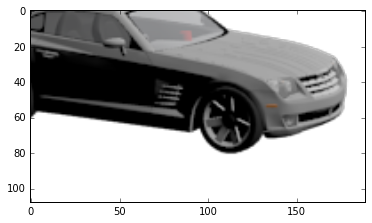

In [17]:
fig,ax = plt.subplots(1)
ax.imshow(getRGBImage(d_crop_img))

In [18]:
d2_crop_img = cropImage(d2_img, d_crop_bbx_wrt_std2)
fig,ax = plt.subplots(1)
ax.imshow(getRGBImage(d2_crop_img))

In [19]:
d_crop_img_mask = cv2.resize(d_crop_img, (224, 224))[:,:,3].astype(bool)
d2_crop_img_mask = cv2.resize(d2_crop_img, (224, 224))[:,:,3].astype(bool)
diff = np.absolute((d_crop_img_mask.astype(int) - d2_crop_img_mask.astype(int)))

print 'Num of diffferent pixels = {}'.format(diff.sum())

diff *= 255
print diff.min()
print diff.max()

plt.imshow(diff.astype(np.uint8), cmap = 'gray', interpolation = 'bicubic')

Num of diffferent pixels = 1028
0
255
